In [1]:
import pandas as pd
import yfinance as yf
import datetime as dt
import mplfinance as mpf
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
from urllib.request import Request
from urllib.request import urlopen
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

In [34]:
# number of news to display per ticker
n = 5

# tickers list to choose, can be improved by making it an input arguement
tickers = ['GOOGL']

In [35]:
# to access a ticker's page on FinViz, the ticker symbol is appended after this specific URL. BeautifulSoup is a commonly used web-scrapping library
finviz_url = 'https://finviz.com/quote.ashx?t='
news_tables = {}

for ticker in tickers:
    url = finviz_url + ticker
    req = Request(url=url,headers={'User-Agent': 'Mozilla/5.0 (Windows NT 6.1; WOW64; rv:20.0) Gecko/20100101 Firefox/20.0'}) 
    resp = urlopen(req)    
    html = BeautifulSoup(resp, features="lxml")
    news_table = html.find(id='news-table')
    news_tables[ticker] = news_table

try:
    for ticker in tickers:
        df = news_tables[ticker]
        df_tr = df.findAll('tr')
    
        print ('\n')
        print ('Recent News Headlines for {}: '.format(ticker))
        
        for i, table_row in enumerate(df_tr):
            a_text = table_row.a.text
            td_text = table_row.td.text
            td_text = td_text.strip()
            print(a_text,'(',td_text,')')
            if i == n-1:
                break
except KeyError:
    pass



Recent News Headlines for GOOGL: 
Top 10 Generative Artificial Intelligence Companies to Invest In ( May-28-23 11:43AM )
1 Semiconductor Stock Set to Join Apple, Microsoft, Amazon, and Alphabet in the $1 Trillion Club ( 10:35AM )
South Koreas Naver to target foreign governments with latest ChatGPT-like AI model ( 12:00AM )
The 5 Best Cheap Phone Plans You Can Get Now ( May-27-23 12:30PM )
Billionaire Stanley Druckenmillers 2023 Portfolio: Top 10 Stock Picks ( 12:22PM )


In [36]:
# Iterating through the news
parsed_news = []
for file_name, news_table in news_tables.items():
    for x in news_table.findAll('tr'):
        text = x.a.get_text() 
        date_scrape = x.td.text.split()

        if len(date_scrape) == 1:
            time = date_scrape[0]
            
        else:
            date = date_scrape[0]
            time = date_scrape[1]

        ticker = file_name.split('_')[0]
        
        parsed_news.append([ticker, date, time, text])

In [37]:
# Using the Vader to perform Sentimental Analysis using its default parameters (not fine-tuned)
analyzer = SentimentIntensityAnalyzer()

columns = ['Ticker', 'Date', 'Time', 'Headline']
news = pd.DataFrame(parsed_news, columns=columns)
scores = news['Headline'].apply(analyzer.polarity_scores).tolist()

df_scores = pd.DataFrame(scores)
news = news.join(df_scores, rsuffix='_right')

In [38]:
# Viewing the overall data and summarising the compound score
news['Date'] = pd.to_datetime(news.Date).dt.date

unique_ticker = news['Ticker'].unique().tolist()
news_dict = {name: news.loc[news['Ticker'] == name] for name in unique_ticker}

values = []
for ticker in tickers: 
    dataframe = news_dict[ticker]
    dataframe = dataframe.set_index('Ticker')
    dataframe = dataframe.drop(columns = ['Headline'])
    print ('\n')
    print (dataframe.head())
    
    mean = round(dataframe['compound'].mean(), 2)
    values.append(mean)
    
df = pd.DataFrame(list(zip(tickers, values)), columns =['Ticker', 'Mean Sentiment']) 
df = df.set_index('Ticker')
df = df.sort_values('Mean Sentiment', ascending=False)
print ('\n')
print (df)



              Date     Time  neg    neu    pos  compound
Ticker                                                  
GOOGL   2023-05-28  11:43AM  0.0  0.588  0.412    0.5994
GOOGL   2023-05-28  10:35AM  0.0  0.782  0.218    0.4404
GOOGL   2023-05-28  12:00AM  0.0  1.000  0.000    0.0000
GOOGL   2023-05-27  12:30PM  0.0  0.682  0.318    0.6369
GOOGL   2023-05-27  12:22PM  0.0  0.816  0.184    0.2023


        Mean Sentiment
Ticker                
GOOGL             0.11


In [39]:
start_date = dt.date.today() - dt.timedelta(days=60)
end_date =  dt.date.today()

stock_data = yf.download(ticker, start=start_date, end=end_date)

[*********************100%***********************]  1 of 1 completed


In [40]:
# Calculating pivot points
def calculate_pivot_points(data):
    pivot_points = pd.DataFrame()
    
    pivot_points['Pivot'] = (data['High'] + data['Low'] + data['Close']) / 3
    
    pivot_points['R1'] = (2 * pivot_points['Pivot']) - data['Low']
    
    pivot_points['S1'] = (2 * pivot_points['Pivot']) - data['High']
    
    pivot_points['R2'] = pivot_points['Pivot'] + (data['High'] - data['Low'])
    
    pivot_points['S2'] = pivot_points['Pivot'] - (data['High'] - data['Low'])
    
    pivot_points['R3'] = data['High'] + 2 * (pivot_points['Pivot'] - data['Low'])
    
    pivot_points['S3'] = data['Low'] - 2 * (data['High'] - pivot_points['Pivot'])
    
    return pivot_points

# Calculate pivot points for the stock data
pivot_points = calculate_pivot_points(stock_data)

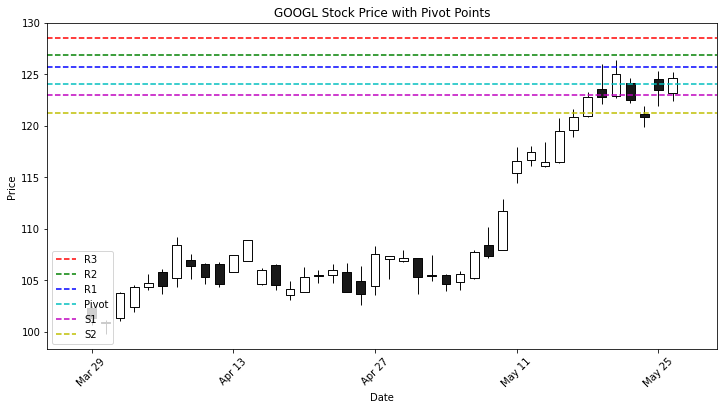

In [41]:
# Create a candlestick chart
fig, ax = plt.subplots(figsize=(12, 6))
mpf.plot(stock_data, type='candle', ax=ax)

# Plot pivot points
pivots = ['R3', 'R2', 'R1', 'Pivot', 'S1', 'S2', 'S3']
colors = ['r', 'g', 'b', 'c', 'm', 'y']
for level, color in zip(pivots, colors):
    ax.axhline(y=pivot_points[level].iloc[-1], linestyle='--', color=color, label=level)
 
# Customize the chart
ax.legend()
ax.set_title(f'{ticker} Stock Price with Pivot Points')
ax.set_xlabel('Date')
ax.set_ylabel('Price')

# Display the chart
plt.show()